CNN 실습 & 과제 코드입니다.

답지는 다음주 목요일 오전 8시에 업로드됩니다.

모두 화이팅 :)

**(기본 code를 바탕으로 빈칸을 채워주세요)**

## Library Import

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

from tensorflow.keras.datasets import cifar10

In [2]:
# GPU 활용
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [3]:
# class 개수 지정
NUM_CLASSES = 10

In [4]:
# CIFAR-10 dataset load
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

- **Assignment 1: X_train, X_test, y_train, y_test의 shape과 형식을 출력해보세요. (각각 출력해도 됩니다!)**

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [6]:
type(X_train), type(X_test), type(y_train), type(y_test) 

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [7]:
# 기본적으로 image data는 pixel channel마다 0~255 integer로 구성되는데,
# 신경망은 input이 -1~1 범위에서 가장 잘 동작하기 때문에 데이터를 255로 나눈다.
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [8]:
# image의 integer label을 one-hot encoding vector로 바꾼다.
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

- **Assignment 2: 변환된 y_train, y_test의 shape을 출력해보세요.**

In [9]:
y_train.shape, y_test.shape

((50000, 10), (10000, 10))

- **Assignment 3: X_train에서, index 54의 이미지에서 (12,13) 위치에 해당하는 픽셀의 초록 채널(1) 값을 출력해보세요. (힌트: X_train[?,?,?,?])**

In [10]:
X_train[54,12,13,1]

0.36862746

## Modeling

Keras에서 신경망 구조를 정의하는 방법은 **Sequential 모델**과 **함수형 API** 두 가지가 있습니다.  

Sequential 모델은 일렬로 층을 쌓은 네트워크를 빠르게 만들 때 사용하기 좋습니다. 즉 어떤 분기가 없이 이전 층이 그대로 다음 층으로 연결됩니다.  
하지만 한 층의 출력이 여러 개의 별도의 층으로 전달되거나, 한 층이 여러 층으로부터 입력을 받는 등의 가지가 있는 네트워크를 만들기 위해서는 유연성이 많은 함수형 API를 사용하는 것이 좋습니다.  
Keras에서도 단순한 모델을 만들더라도 Sequential 모델보다 함수형 API를 권장합니다. 장기적으로 보면 모델이 점점 복잡한 구조가 될 수 있기 때문입니다.  
함수형 API는 Deep Neural Network 구조를 설계하는 데에 있어 엄청난 자유를 제공합니다.

따라서 본 assignment에서는 함수형 API를 사용하여 Modeling을 진행하였습니다.

In [11]:
input_layer = Input(shape=(32,32,3))


x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)


model = Model(input_layer, output_layer)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                             

## Train

In [13]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


- **Assignment 4: loss를 categorical_crossentropy로 설정한 이유는 무엇일까요?**
- 답: 다중 분류 문제이므로 crossentropy를 사용해야 합니다. 또한  앞서 label에 대해 one-hot encoding을 해주었으므로 categorical_crossentropy가 적합한 loss입니다.

In [14]:
BATCH_SIZE = 32
EPOCHS = 10

In [15]:
model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          shuffle=True,
          validation_data=(X_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 10s 5ms/step - loss: 1.4649 - accuracy: 0.4782 - val_loss: 1.1535 - val_accuracy: 0.5870
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1036 - accuracy: 0.6117 - val_loss: 1.0326 - val_accuracy: 0.6374
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.9711 - accuracy: 0.6612 - val_loss: 0.9937 - val_accuracy: 0.6543
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8878 - accuracy: 0.6901 - val_loss: 0.9059 - val_accuracy: 0.6811
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8190 - accuracy: 0.7143 - val_loss: 0.9455 - val_accuracy: 0.6735
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.7692 - accuracy: 0.7299 - val_loss: 1.0327 - val_accuracy: 0.6501
Epoch 7/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.7248 - accuracy: 0.7464 - val_loss: 0.9064 - val_accuracy

In [16]:
model.layers[6].get_weights()

[array([[[[-0.09414706, -0.09558804,  0.00701401, ..., -0.07193226,
           -0.01689216, -0.0756039 ],
          [ 0.10265303,  0.01317095,  0.00186906, ..., -0.0006616 ,
           -0.01626873,  0.01027622],
          [-0.08460251,  0.06224431,  0.06089879, ...,  0.01705534,
            0.02281079, -0.02728002],
          ...,
          [-0.05242365, -0.05339586, -0.01267407, ..., -0.06339881,
            0.03710023, -0.11113911],
          [ 0.1585179 , -0.0183713 , -0.11967636, ..., -0.03446296,
           -0.04478415, -0.03657199],
          [ 0.06893144,  0.04202163,  0.03719153, ..., -0.051942  ,
           -0.11478028,  0.06157564]],
 
         [[-0.01426496, -0.04660713, -0.03677551, ..., -0.03596677,
            0.0509852 ,  0.08451135],
          [ 0.0108681 , -0.01972676, -0.1074733 , ...,  0.01092089,
           -0.04251952,  0.05987326],
          [-0.06131294, -0.00127937,  0.00227041, ..., -0.01638694,
            0.02573663,  0.00648907],
          ...,
          [-0

## Evaluate

In [17]:
model.evaluate(X_test, y_test, batch_size=1000)

10/10 [==============================] - 1s 20ms/step - loss: 0.9432 - accuracy: 0.6934


[0.9431605339050293, 0.6934000253677368]

[loss, accuracy] 가 출력된다.  
결과를 시각화해 보자.

In [18]:
CLASSES = np.array(['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])

preds = model.predict(X_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

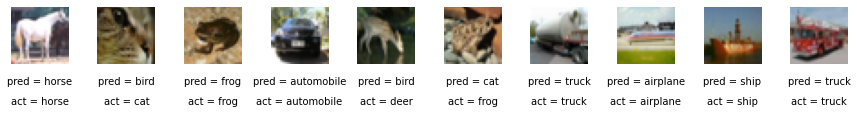

In [19]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(X_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, idx in enumerate(indices):
    img = X_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

**- Assignment 5: model및 training 환경을 자유롭게 변경하여 Accuracy 75% 이상을 달성해 보세요!**

In [ ]:
## 위의 모델을 참고해 만들어보세요
## 새로운 방법도 좋아요!
## 화이팅 :D

In [20]:
input_layer = Input(shape=(32,32,3))

x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = MaxPooling2D(pool_size=2)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

x = Dense(256)(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

x = Dense(128)(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

x = Dense(64)(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

x = Dense(32)(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)


model = Model(input_layer, output_layer)

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        1849

In [22]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
model.fit(X_train,
          y_train,
          batch_size=512,
          epochs=70,
          shuffle=True,
          validation_data=(X_test, y_test))

Epoch 1/70
98/98 [==============================] - 4s 37ms/step - loss: 0.0606 - accuracy: 0.9852 - val_loss: 1.9426 - val_accuracy: 0.7506
Epoch 2/70
98/98 [==============================] - 3s 34ms/step - loss: 0.0415 - accuracy: 0.9901 - val_loss: 2.4161 - val_accuracy: 0.7673
Epoch 3/70
98/98 [==============================] - 3s 34ms/step - loss: 0.0551 - accuracy: 0.9865 - val_loss: 2.2339 - val_accuracy: 0.7266
Epoch 4/70
98/98 [==============================] - 3s 35ms/step - loss: 0.0427 - accuracy: 0.9888 - val_loss: 2.1451 - val_accuracy: 0.7714
Epoch 5/70
98/98 [==============================] - 3s 35ms/step - loss: 0.0497 - accuracy: 0.9873 - val_loss: 2.4904 - val_accuracy: 0.7429
Epoch 6/70
98/98 [==============================] - 3s 35ms/step - loss: 0.0478 - accuracy: 0.9882 - val_loss: 2.1513 - val_accuracy: 0.7805
Epoch 7/70
98/98 [==============================] - 3s 35ms/step - loss: 0.0525 - accuracy: 0.9871 - val_loss: 2.8573 - val_accuracy: 0.7380
Epoch 8/70
98

In [26]:
model.evaluate(X_test, y_test, batch_size=1000)

10/10 [==============================] - 0s 23ms/step - loss: 2.6457 - accuracy: 0.7574


[2.6456704139709473, 0.7573999762535095]